In [1]:
import sys
sys.path.append(sys.path[0] + "/..")

%load_ext autoreload
%autoreload 2

from IPython.core.display import display, clear_output, HTML, Javascript
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("../experiments/data/interim/DIJA-2006-2018-clean.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

In [3]:
df.head()

,Open,High,Low,Close,Name
Date,,,,,
2006-01-03,77.76,79.35,77.24,79.11,MMM
2006-01-04,79.49,79.49,78.25,78.71,MMM
2006-01-05,78.41,78.65,77.56,77.99,MMM
2006-01-06,78.64,78.90,77.64,78.63,MMM
2006-01-09,78.50,79.83,78.46,79.02,MMM


In [21]:
from hedgepy.core import HedgeFrame
from memoization import cached

@cached 
def build_dcor_network(df, ticker_col_name, rolling_window=90):
    hf = HedgeFrame(df=df, ticker_col_name=ticker_col_name)
    _90d_dcor_network = hf.dcor(rolling_window=rolling_window)
    return _90d_dcor_network
# @cached
# def build_correlation_matrix_time_series(df, ticker_col_name, rolling_window):
#     hf = HedgeFrame(df, ticker_col_name)
#     numpy_time_series_dict = hf.build_correlation_matrix_time_series(rolling_window=rolling_window)
#     return numpy_time_series_dict
    

# _90d_dcor_network = hf.build_dcor_network_time_series(rolling_window=90)

In [20]:
_90d_dcor_network = build_dcor_network(df, 'Name', 90)

In [33]:
from hedgepy.utils import read, write

write(_90d_dcor_network, 'dija_2006-18-rolling_90d_dcor.json')

In [25]:
keys = list(_90d_dcor_network.keys())
values = list(_90d_dcor_network.values())

keys = map(lambda timestamp: str(timestamp), keys)
values = map(lambda df: df.to_dict('records'), values)

_90d_dcor_network_json = dict(zip(keys,values))

In [27]:
import json
with open('_90d_dcor_network.json', 'w') as f:
    json.dump(_90d_dcor_network_json, f)

In [71]:
# from hedgepy.core import build_correlation_network
# import networkx as nx

# @cached
# def build_global_clustering_time_series(nx_time_series, corr_threshold=None):
#     nx_network_time_series = {
#         time_series: build_correlation_network(df_dcor, corr_threshold=corr_threshold)
#         for time_series, df_dcor in nx_time_series.items()
#     }
    
#     global_clustering_ts = {
#         timestamp: nx.average_clustering(df, weight='weight') for timestamp, df in nx_network_time_series.items()
#     }
    
#     return global_clustering_ts

In [65]:
# frame = build_correlation_matrix_time_series(df, 'Name', rolling_window=90)

In [69]:
global_clustering_ts = build_global_clustering_time_series(frame)
df_clustering = pd.DataFrame.from_dict(global_clustering_ts, orient='index')\
        .rename(columns={0: '90d_global_clustering_coefficient'})

In [38]:
df_clustering.head()

,90d_global_clustering_coefficient
2006-05-12,0.453719
2006-05-15,0.472583
2006-05-16,0.474465
2006-05-17,0.469718
2006-05-18,0.466833


In [14]:
import networkx as nx
from scipy.stats import mstats

def average_communicability_betweenness(G):
    cbc = nx.communicability_betweenness_centrality(G)
    average_cbc = np.mean(list(cbc.values()))
    return average_cbc

def average_degree_centrality(G):
    dc = nx.degree_centrality(G)
    avg_dc = np.mean(list(dc.values()))
    return avg_dc

def average_eigenvector_centrality(G):
    ec = nx.eigenvector_centrality(G, weight='weight')
    avg_ec = mstats.gmean(list(ec.values()))
    return avg_ec

nx_time_series = {
    timestamp: average_eigenvector_centrality(dcor_network) 
     for timestamp, dcor_network in _90d_dcor_network.items()
}

# nx_time_series = {
#     timestamp: average_eigenvector_centrality(dcor_network) 
#      for timestamp, dcor_network in _90d_dcor_network.items()
# }
    
df_clustering = pd.DataFrame.from_dict(nx_time_series, orient='index')\
    .rename(columns={0: '90d_global_clustering_coefficient'})

AttributeError: 'DataFrame' object has no attribute 'is_directed'

In [216]:
test = df_clustering.to_numpy()
df_test = pd.DataFrame(test)
df_test.columns = df_clustering.columns
df_test.index = df_clustering.index

In [217]:
df_test.head()

,90d_global_clustering_coefficient
2006-05-12,0.037676
2006-05-15,0.033724
2006-05-16,0.017135
2006-05-17,0.057661
2006-05-18,0.085318


In [6]:
# df_clustering.to_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-eigenvector-soft-thresh.csv')

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style()

In [41]:
df_dija_index = pd.read_csv('../experiments/data/raw/DIJA-index-2006-2018.csv')

In [42]:
df_dija_index['Date'] = pd.to_datetime(df_dija_index['Date'])

In [43]:
df_dija_index.set_index('Date', inplace=True)

In [141]:
dft = pd.read_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-degree-0.33corr-thresh.csv')
dft = dft.rename(columns={'Unnamed: 0': 'Date'})
dft['Date'] = pd.to_datetime(dft['Date'])
dft.set_index('Date', inplace=True)

In [120]:
dft2 = pd.read_csv('../experiments/data/processed/DIJA-2006-2008-90d-dcor-nx-degree-0.5corr-thresh.csv')
dft2 = dft2.rename(columns={'Unnamed: 0': 'Date'})
dft2['Date'] = pd.to_datetime(dft2['Date'])
dft2.set_index('Date', inplace=True)

In [28]:
test = df_dija_index['Close'].pct_change().rolling(30).std()

Text(0, 0.5, 'DIJA Index')

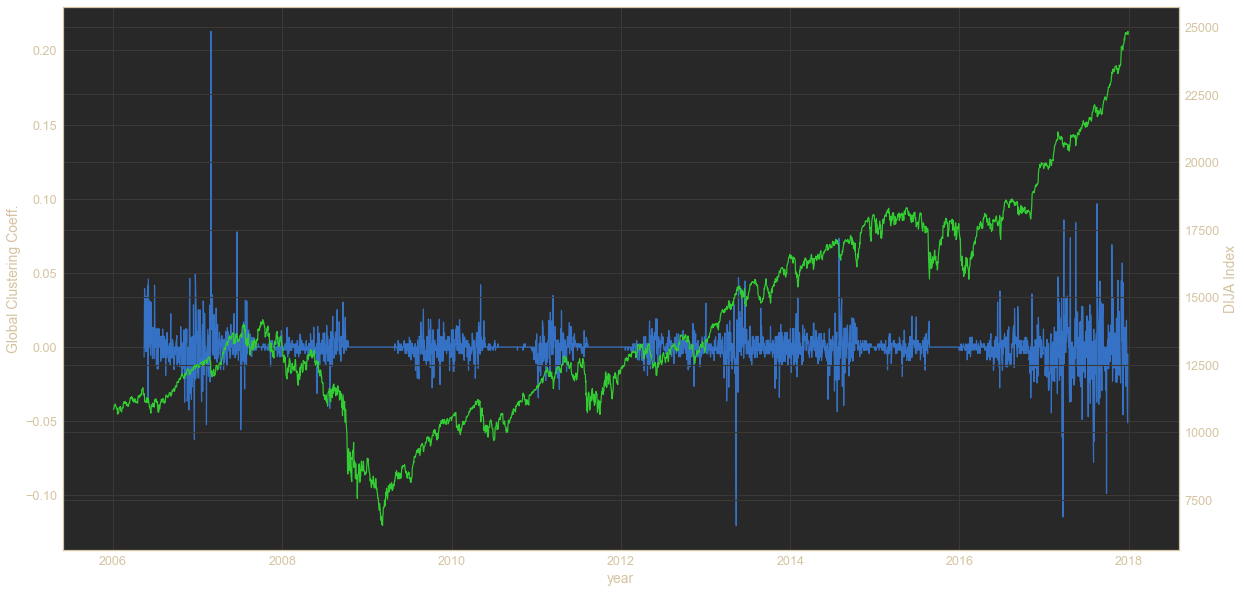

In [191]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.pct_change())
# ax.plot(dft2.shift(periods=120))
ax.set_xlabel("year", fontsize=14)
ax.set_ylabel("Global Clustering Coeff.", fontsize=14)

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)

In [189]:
dft['90d_global_clustering_coefficient'].corr(df_dija_index.shift(periods=800)['Close'])

-0.5602794744929882

In [256]:
dft = df_clustering

In [305]:
dft_pos = dft.pct_change()[dft.pct_change()['90d_global_clustering_coefficient'] >=0]

In [335]:
# dft_pos.columns = ['crisis_coeff']
# dft_pos.dropna(inplace=True)

In [39]:
dft['crisis_coeff'] = dft[['90d_global_clustering_coefficient']].pct_change()

In [109]:
dft = dft.replace([np.inf, -np.inf], np.nan)

In [40]:
dft.dropna(inplace=True)

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
import math

def optimize_OneClassSVM(X, n):
    print('searching for optimal hyperparameters...')
    nu = np.linspace(start=1e-5, stop=1e-2, num=n)
    gamma = np.linspace(start=1e-6, stop=1e-3, num=n)
    opt_diff = 1.0
    opt_nu = None
    opt_gamma = None
    for i in range(len(nu)):
        for j in range(len(gamma)):
            classifier = OneClassSVM(kernel="rbf", nu=nu[i], gamma=gamma[j])
            classifier.fit(X)
            label = classifier.predict(X)
            p = 1 - float(sum(label == 1.0)) / len(label)
            diff = math.fabs(p - nu[i])
            if diff < opt_diff:
                opt_diff = diff
                opt_nu = nu[i]
                opt_gamma = gamma[j]
    return opt_nu, opt_gamma

In [41]:
data = dft[['crisis_coeff']]
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled).dropna()

opt_nu, opt_gamma = optimize_OneClassSVM(data, n=20)

searching for optimal hyperparameters...


In [42]:
opt_nu

0.006845263157894737

In [43]:
opt_gamma

0.00010615789473684212

In [271]:
p = 1/len(dft)

In [44]:
#train OneClassSVM
model = OneClassSVM(nu=0.02, kernel="rbf", gamma=opt_gamma)
model.fit(data)
anomalies = pd.Series(model.predict(data), index=dft.index)

In [273]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.001, behaviour='new')
model.fit(data)
anomalies = pd.Series(model.predict(data), index=dft.index)

In [45]:
dft['anomaly'] = anomalies

In [46]:
dft['dija'] = df_dija_index['Close']

In [50]:
size=np.abs([(i*10000)*1.5 for i in a['crisis_coeff'].tolist()])
size

array([ 625.        ,  688.0733945 ,  625.        ,  557.14285714,
        545.45454545,  637.25490196,  693.06930693,  934.25605536,
        735.8490566 ,  549.45054945,  786.51685393, 3192.77108434,
       1192.05298013, 1165.04854369,  837.05357143,  620.4379562 ,
        629.37062937,  546.11650485, 1804.81283422,  700.93457944,
        668.31683168,  653.84615385, 1098.5915493 ,  592.59259259,
        665.68047337,  709.09090909,  681.81818182,  910.54313099,
       1718.75      ,  588.23529412, 1285.71428571,  557.43243243,
       1105.26315789,  550.        , 1259.54198473,  732.8990228 ,
        704.69798658,  568.96551724, 1166.66666667,  952.38095238,
        572.03389831,  558.13953488, 1449.27536232,  594.71365639,
        557.85123967,  579.39914163,  602.67857143,  666.66666667,
       1480.68669528, 1034.48275862,  675.        ,  668.31683168,
        849.05660377,  649.35064935,  684.6473029 ,  652.17391304,
        666.66666667,  767.44186047])

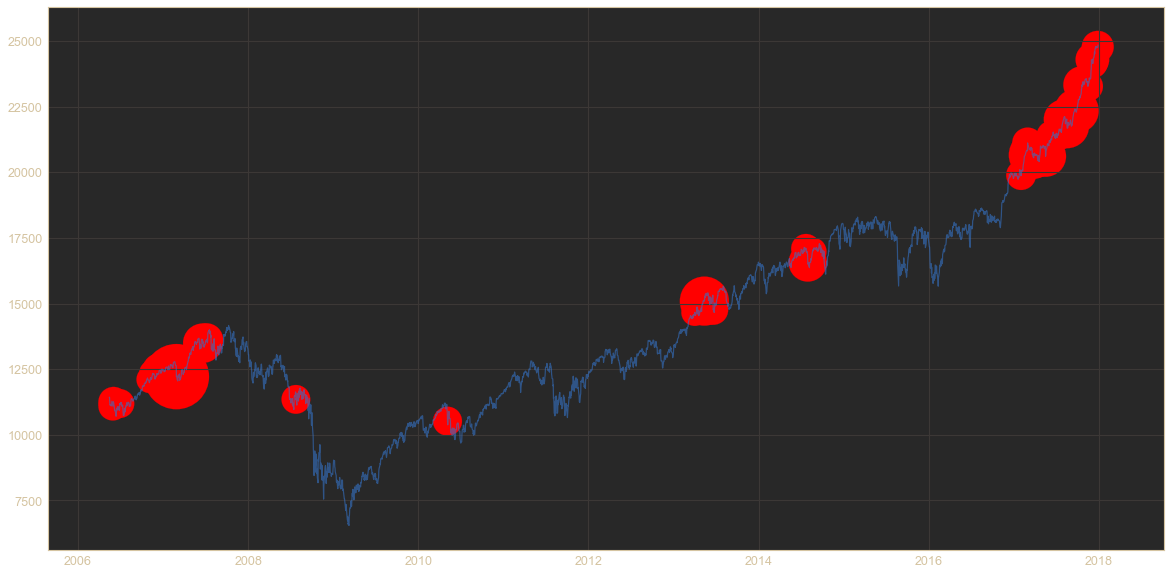

In [49]:
a = dft.loc[dft['anomaly'] == -1]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['dija'], label='Normal', alpha=0.6)
ax.scatter(a.index, dft['dija'][dft['anomaly']==-1], color='red', label='Anomaly', s=size)

In [52]:
dft[(dft['anomaly'] == -1)]

,90d_global_clustering_coefficient,crisis_coeff,anomaly,dija
Date,,,,
2006-05-30,0.752688,0.041667,-1,11094.42969
2006-06-02,0.735484,0.045872,-1,11247.87012
2006-06-29,0.860215,0.041667,-1,11190.79981
2006-11-06,0.724731,-0.037143,-1,12105.54981
2006-11-17,0.683871,-0.036364,-1,12342.55957
2006-11-24,0.630108,-0.042484,-1,12280.16992
2006-11-28,0.681720,0.046205,-1,12136.45020
2006-12-18,0.582796,-0.062284,-1,12441.26953
2006-12-22,0.597849,0.049057,-1,12343.21973


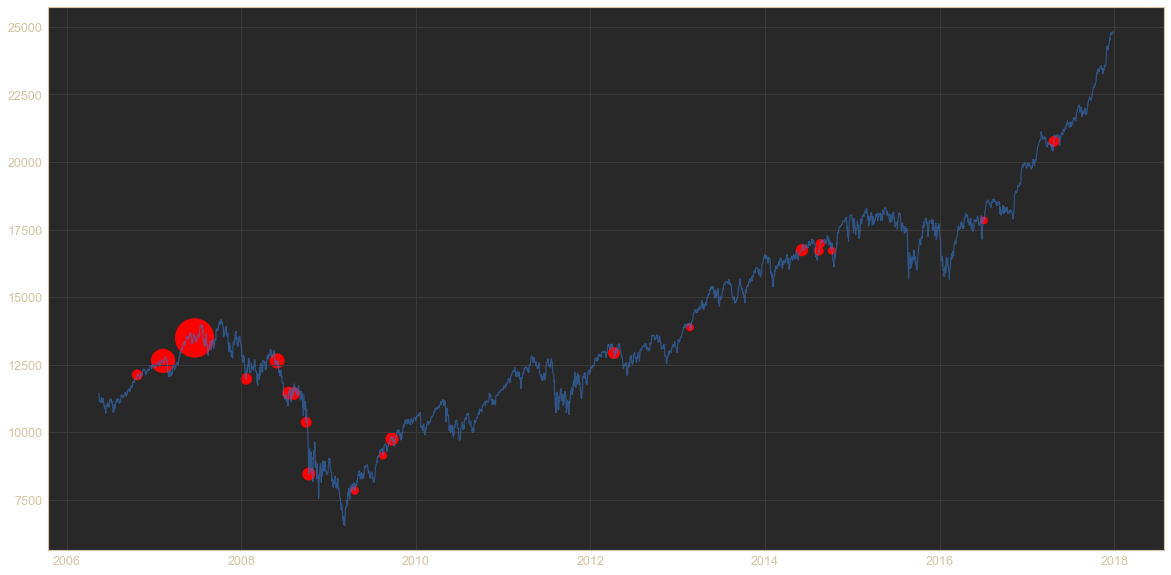

In [340]:
a = dft.loc[dft['anomaly'] == -1]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['dija'], label='Normal', alpha=0.6)
ax.scatter(a.index, dft['dija'][dft['anomaly']==-1], color='red', label='Anomaly', s=size)

# ax2 = ax.twinx()
# ax2.plot(df_dija_index['Close'], color='limegreen')
# ax2.set_ylabel('DIJA Index', fontsize=14)
# plt.legend()

In [119]:
from hurst import compute_Hc
H, c, dta =  compute_Hc(dft['90d_global_clustering_coefficient'])

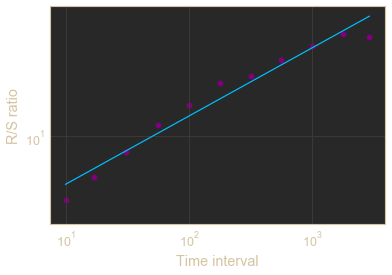

H=0.4269, c=1.8719


In [120]:
f, ax = plt.subplots()
ax.plot(dta[0], c*dta[0]**H, color="deepskyblue")
ax.scatter(dta[0], dta[1], color="purple")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Time interval')
ax.set_ylabel('R/S ratio')
ax.grid(True)
plt.show()

print("H={:.4f}, c={:.4f}".format(H,c))

In [267]:
dft[(dft['anomaly'] == -1)]

,90d_global_clustering_coefficient,crisis_coeff,anomaly,dija
2006-10-23,0.178757,0.000666,-1,12116.910160
2007-02-08,0.179043,-0.001275,-1,12637.629880
2007-06-20,0.178976,0.001881,-1,13489.419920
2008-01-22,0.179047,0.000704,-1,11971.190430
2008-05-30,0.178160,-0.000867,-1,12638.320310
2008-07-17,0.177713,-0.000763,-1,11446.660160
2008-08-07,0.178005,0.000771,-1,11431.429690
2008-09-29,0.178450,0.000668,-1,10365.450200
2008-10-10,0.178982,0.000772,-1,8451.190430
2009-04-20,0.178993,-0.000543,-1,7841.729980


2020-04-28 23:06:49,975 [23416] WARNING  matplotlib.legend:1282: [JupyterRequire] No handles with labels found to put in legend.


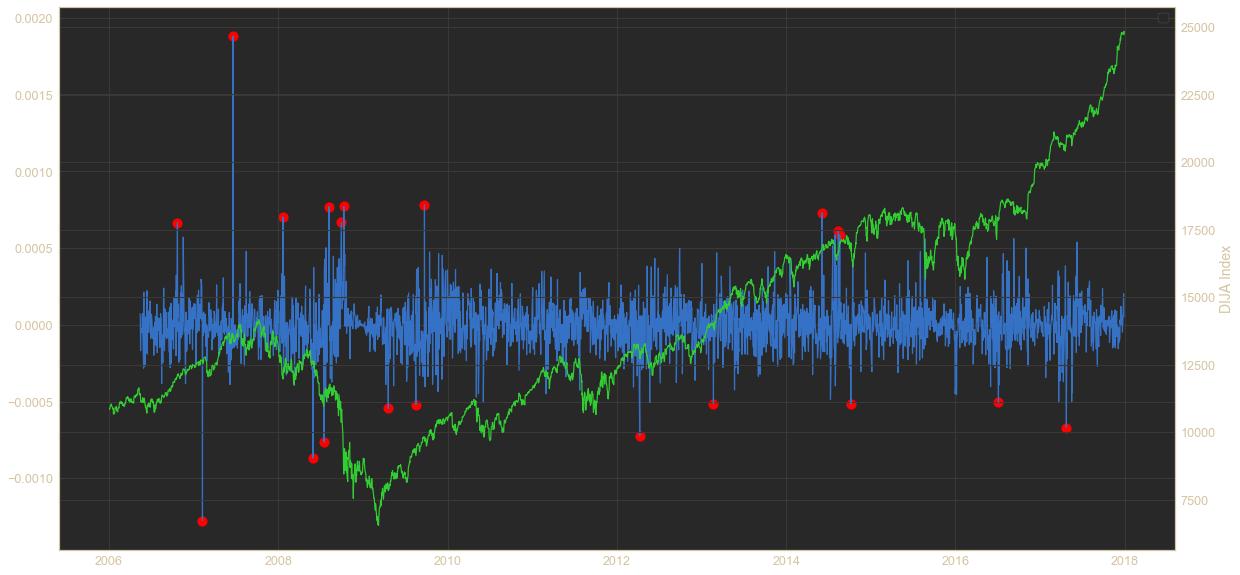

In [291]:
a = dft.loc[dft['anomaly'] == -1, ['crisis_coeff']]
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(dft.index, dft['crisis_coeff'], label='Normal')
ax.scatter(a.index, a['crisis_coeff'], color='red', label='Anomaly')

ax2 = ax.twinx()
ax2.plot(df_dija_index['Close'], color='limegreen')
ax2.set_ylabel('DIJA Index', fontsize=14)
plt.legend()

In [207]:
dft[(dft['anomaly'] == -1)] 

,90d_global_clustering_coefficient,crisis_coeff,anomaly,dija
2006-06-28,0.000000,-1.000000,-1,10973.55957
2006-07-12,0.000000,-1.000000,-1,11013.17969
2006-08-04,0.073451,2.635851,-1,11240.34961
2006-10-23,0.055812,-0.656718,-1,12116.91016
2006-10-24,0.109258,0.957600,-1,12127.87988
2006-11-09,0.000000,-1.000000,-1,12103.29981
2007-04-10,0.000000,-1.000000,-1,12573.84961
2007-06-28,0.114622,1.272159,-1,13422.28027
2007-07-18,0.000000,-1.000000,-1,13918.21973
2007-07-20,0.000000,-1.000000,-1,13851.08008


In [265]:
import ipyhc as hc

dija_index_series = hc.build.series(df_dija_index[['Close']])
df_clustering_series = hc.build.series(dft[['90d_global_clustering_coefficient']])

In [266]:
df_clustering_series[0]['yAxis'] = 1

In [267]:
options = {
    'credits': {'enabled': True,
                'text': 'Source: XXX Flow Strategy & Solutions.',
                'href': 'http://www.example.com'},
    'exporting': {'enabled': True},
    'chart': {'zoomType': 'xy'},
    'plotOptions': {'series': {'compare': 'percent'}},
    'legend': {'enabled': True,
               'layout': 'horizontal',
               'align': 'center',
               'maxHeight': 100},
    'tooltip': {'enabled': True,
                'valueDecimals': 5,
                'pointFormat': '<span style="color:{series.color}">{series.name}</span>: <b>{point.y}</b> ({point.change}%)<br/>',
                'positioner': "function(labelWidth, labelHeight, point) {\n    var roundUp100 = function(d) { return 100*Math.floor(d/100); },\n        labelWidth = roundUp100(labelWidth),\n        chart = window.charts['__uuid__'];\n\n    var tooltipX, tooltipY;\n        var testX = (point.plotX + labelWidth * 0.7 > chart.plotWidth / 2) && (point.plotX - labelWidth * 0.7 < chart.plotWidth / 2);\n        var testY = point.plotY < labelHeight * 0.7;\n\n    if (testX && testY) {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop + chart.plotHeight - labelHeight;\n    } else {\n                tooltipX = chart.plotLeft + (chart.plotWidth - labelWidth) / 2;\n        tooltipY = chart.plotTop;\n    }\n\n    return {\n        x: tooltipX,\n        y: tooltipY\n    };\n}\n\n"},
    'title': {'text': 'Time series plotted with HighStock'},
    'subtitle': {'text': 'Transparent access to the underlying js lib'},
    'yAxis': [
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
        },
        {
            'gridLineWidth': 1.0,
            'gridLineDashStyle': 'Dot',
            'title': {
                'text': '% change'
            }
        }
    ],
    'xAxis': {
        'gridLineWidth': 1.0, 
        'gridLineDashStyle': 'Dot'},
}

chart = hc.Chart(height=600, width=1200, stock = True, options = options, data = dija_index_series + df_clustering_series)
chart

Chart(height='600px', stock=True, width='1200px')

In [19]:
from alpha_vantage.timeseries import TimeSeries
key = '34CW4J294SBIRRAM'
ts = TimeSeries(key, output_format='pandas')
data, meta_data = ts.get_daily_adjusted(symbol='DIA', outputsize='full')

In [15]:
data.head()

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2000-06-30,143.9375,145.5937,143.8906,145.2812,99.2910,7420200.0,0.0,1.0
2000-07-03,145.4375,147.4375,145.1875,147.2812,100.6579,1436600.0,0.0,1.0
2000-07-05,146.3750,146.6562,144.3750,144.6250,98.8425,2748200.0,0.0,1.0
2000-07-06,144.9375,146.4687,144.2187,145.7500,99.6114,5963200.0,0.0,1.0
2000-07-07,146.6875,148.7812,146.2500,148.0937,101.2132,3034800.0,0.0,1.0


In [16]:
meta_data

{'1. Information': 'Daily Time Series with Splits and Dividend Events',
 '2. Symbol': 'SPY',
 '3. Last Refreshed': '2020-07-02 11:54:54',
 '4. Output Size': 'Full size',
 '5. Time Zone': 'US/Eastern'}

In [5]:
import matplotlib.pyplot as plt
t = aapl_data.copy()
t['date'] = t.index

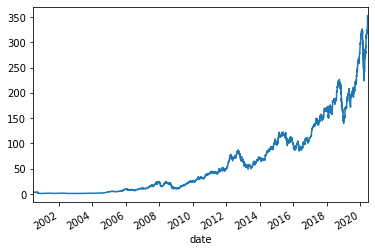

In [10]:
t['5. adjusted close'].plot()

In [16]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="1d")

In [17]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-08,185.94,186.49,184.44,186.41,15192353,0,0


In [15]:
dja = yf.Ticker("DJIA")
dja.history(period='max')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1921-01-03,72.67,72.67,72.67,72.67,0,0,0
1921-01-04,72.76,72.76,72.76,72.76,0,0,0
1921-01-05,73.13,73.13,73.13,73.13,0,0,0
1921-01-06,74.31,74.31,74.31,74.31,0,0,0
1921-01-07,75.21,75.21,75.21,75.21,0,0,0
1921-01-10,76.00,76.00,76.00,76.00,0,0,0
1921-01-11,76.14,76.14,76.14,76.14,0,0,0
1921-01-12,75.88,75.88,75.88,75.88,0,0,0
1921-01-13,74.43,74.43,74.43,74.43,0,0,0
